In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.window import Window
from pyspark.sql.functions import split, arrays_zip, col, explode,regexp_replace

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('ReadData').getOrCreate()
context = spark.sparkContext
from pyspark.sql import HiveContext
hive_context = HiveContext(context)

In [3]:
spark

In [4]:
!hdfs dfs -put /home/xtang36/data/yelp_dataset/dataset_review.json /user/xtang36/data/yelp_dataset/dataset_review.json
#!hdfs dfs -put /home/xtang36/data/yelp_dataset /user/xtang36/data/yelp_dataset
!hdfs dfs -ls /user/xtang36/data/yelp_dataset

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
put: `/user/xtang36/data/yelp_dataset/dataset_review.json': File exists
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Found 6 items
-rw-r--r--   3 xtang36 xtang36      80358 2022-03-12 01:01 /user/xtang36/data/yelp_dataset/Dataset_User_Agreement.pdf
-rw-r--r--   3 xtang36 xtang36 5341868833 2022-03-12 01:01 /user/xtang36/data/yelp_dataset/dataset_review.json
-rw-r--r--   3 xtang36 xtang36  118863795 2022-03-12 01:01 /user/xtang36/data/yelp_dataset/yelp_academic_dataset_business.json
-rw-r--r--   3 xtang36 xtang36  286958945 2022-03-12 01:00 /user/xtang36/data/yelp_dataset/yelp_academic_dataset_checkin.json
-rw-r--r--   3 xtang36 xtang36  180604475 2022-03-12 01:01 /user/xtang36/data/yelp_dataset/yelp_academic_dataset_tip.json
-rw-r--r--   3 xtang36 xtang36 3363329011 2022-03-12 01:00 /user/xtang36/data/yelp_dataset/yelp_academ

In [5]:
path = '/user/xtang36/data/yelp_dataset/dataset_review.json'
df_review=spark.read.json(path)
df_review.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [6]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [7]:
df_review_aspect = df_review.withColumn("label", df_review["stars"].cast("double"))
df_review_aspect.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-----+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|label|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|  3.0|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|  5.0|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|  3.0|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|  5.0|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15| 

In [8]:
df_review_aspect = df_review_aspect.select('stars','date','text', 'label')
df_review_aspect.count()

6990280

In [9]:
import nltk

In [10]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
from functools import reduce
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from contextlib import redirect_stdout
import os
import matplotlib.pyplot as pat
from wordcloud import WordCloud 
import pandas as pd
import re
import matplotlib.pyplot as plt
import string
from contextlib import redirect_stdout
import numpy as np
from PIL import Image


/software/Anaconda3-5.1.0-hadoop/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [11]:
#Form subset

goodreview = df_review_aspect.filter(df_review_aspect.label.isin(4.0,5.0))
badreview = df_review_aspect.filter(df_review_aspect.label.isin(1.0,2.0))

### change df to RDD
good_rdd = goodreview.select("text").rdd.flatMap(lambda x: x)
bad_rdd = badreview.select("text").rdd.flatMap(lambda x: x)

### ---Data preprocessing

### change into lower case

good_rdd = good_rdd.map(lambda x : x.lower())
bad_rdd = bad_rdd.map(lambda x : x.lower())

good_rdd.take(10)

["i've taken a lot of spin classes over the years, and nothing compares to the classes at body cycle. from the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nfor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).\n\nthere is no way i can write this review without giving russell, the owner of body cycle, a shout out. russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed. he is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone. russell always wears a smile on his face, even when he's kicking your butt in class!",
 "wow!  yummy, different,  delicious.   our favorite is the lamb curry and korma.  with 10 different kinds of naan!!!  don't let the outside deter you (because we

In [12]:
### sentence tokenization
#nltk.download()
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)

sentence_good_rdd = good_rdd.map(sent_TokenizeFunct)
sentence_bad_rdd = bad_rdd.map(sent_TokenizeFunct)

sentence_good_rdd.take(5)

[["i've taken a lot of spin classes over the years, and nothing compares to the classes at body cycle.",
  'from the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.',
  "for anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).",
  'there is no way i can write this review without giving russell, the owner of body cycle, a shout out.',
  "russell's passion for fitness and cycling is so evident, as is his desire for all of his clients to succeed.",
  'he is always dropping in to classes to check in/provide encouragement, and is open to ideas and recommendations from anyone.',
  "russell always wears a smile on his face, even when he's kicking your butt in class!"],
 ['wow!',
  'yummy, different,  delicious.',
  'our favorite is the lamb curry and korma.',
  'with 10 different kinds of naan!!!',
  "d

In [13]:
### word tokenisation
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted

word_good_rdd = sentence_good_rdd.map(word_TokenizeFunct)
word_bad_rdd = sentence_bad_rdd.map(word_TokenizeFunct)

#word_good_rdd.take(5)

In [14]:
### rmv stopwords

 
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

stop_good_rdd = word_good_rdd.map(removeStopWordsFunct)
stop_bad_rdd = word_bad_rdd.map(removeStopWordsFunct)

In [15]:
### Rmv Punctuations

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rmvPunct_good_rdd = stop_good_rdd.map(removePunctuationsFunct)
rmvPunct_bad_rdd = stop_bad_rdd.map(removePunctuationsFunct)

In [16]:
### Lemmatization

def lemmatizationFunct(x):
    #nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lem_good_RDD = rmvPunct_good_rdd.map(lemmatizationFunct)
lem_bad_RDD = rmvPunct_bad_rdd.map(lemmatizationFunct)

In [17]:
### Extract Noun phrases

def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x

joinedTokens_good = lem_good_RDD.map(joinTokensFunct)
joinedTokens_bad = lem_bad_RDD.map(joinTokensFunct)

In [18]:
joinedTokens_good.take(5)

['ive taken lot spin class year nothing compare class body cycle nice clean space amazing bike welcoming motivating instructor every class top notch work out anyone struggle fit workout in online scheduling system make easy plan ahead and there need line way advanced like many gym make do way write review without giving russell owner body cycle shout out russell passion fitness cycling evident desire client succeed always dropping class check inprovide encouragement open idea recommendation anyone russell always wear smile face even he kicking butt class',
 'wow yummy different delicious favorite lamb curry korma 10 different kind naan let outside deter because almost changed mindsgo try something new glad did',
 'cute interior owner  gave u tour upcoming patiorooftop area great beautiful day like today cheese curd good filling really like sandwich come w salad esp eating many curd onion gruyere tomato sandwich much cheese liked needed something elsepepper jelly maybe would like see me

In [19]:
### POS Nouns
def extractPhraseFunct(x):
    #stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
           temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

extractphrase_good_RDD = joinedTokens_good.map(extractPhraseFunct)
extractphrase_bad_RDD = joinedTokens_bad.map(extractPhraseFunct)


In [20]:
#4. Sentiment analysis
def sentimentWordsFunct(x):
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list


sentiment_good_RDD = extractphrase_good_RDD.map(sentimentWordsFunct)
sentiment_bad_RDD = extractphrase_bad_RDD.map(sentimentWordsFunct)


In [21]:
#5. Top frequency word

from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))

freqDist_good_RDD = extractphrase_good_RDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)
#freqDist_good_RDD.take(20)

freqDist_bad_RDD = extractphrase_bad_RDD.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)
#freqDist_bad_RDD.take(20)

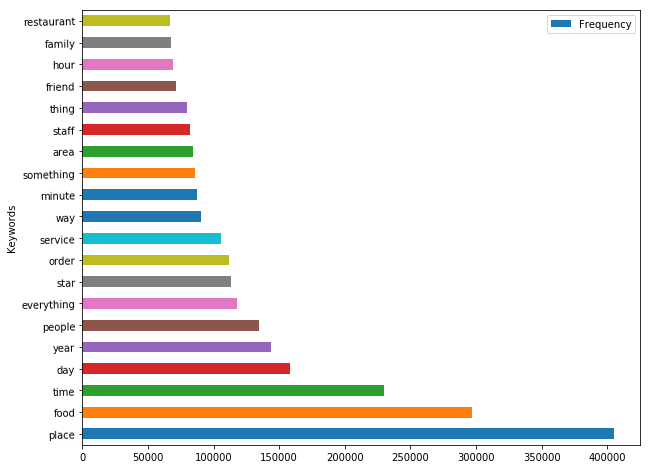

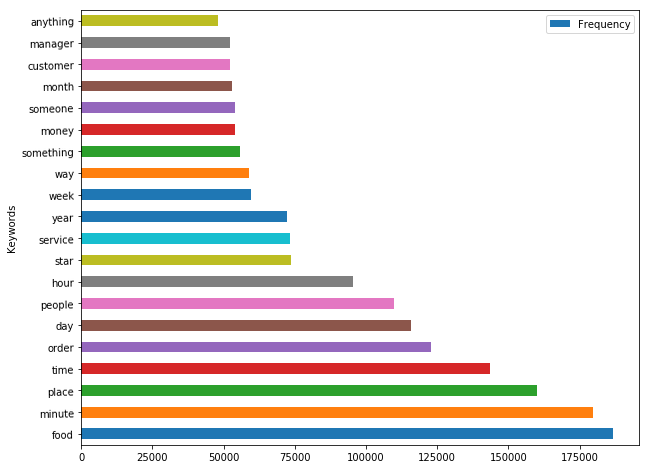

In [22]:
#6. Visualization

### Bar chart
df_good_Dist = freqDist_good_RDD.toDF() #converting RDD to spark dataframe
df_good_Dist.createOrReplaceTempView("myTable") 
df2_good = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20") #renaming columns 
pandD_good = df2_good.toPandas() #converting spark dataframes to pandas dataframes
pandD_good.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))


df_bad_Dist = freqDist_bad_RDD.toDF() #converting RDD to spark dataframe
df_bad_Dist.createOrReplaceTempView("myTable") 
df2_bad = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 20") #renaming columns 
pandD_bad = df2_bad.toPandas() #converting spark dataframes to pandas dataframes
pandD_bad.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

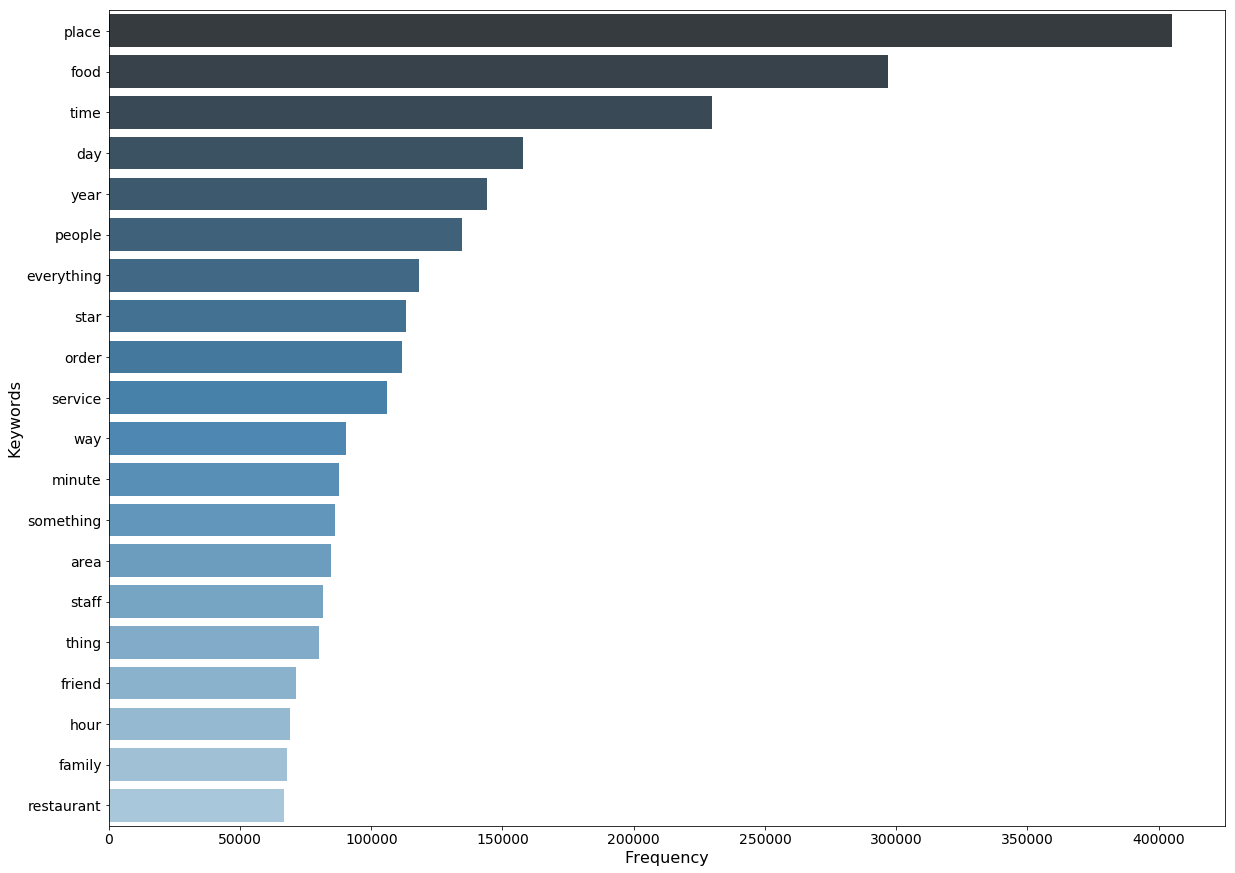

In [23]:
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.barplot(x='Frequency', y='Keywords',data=pandD_good, palette="Blues_d")
plt.xlabel('Frequency', fontsize=16);
plt.ylabel('Keywords', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)

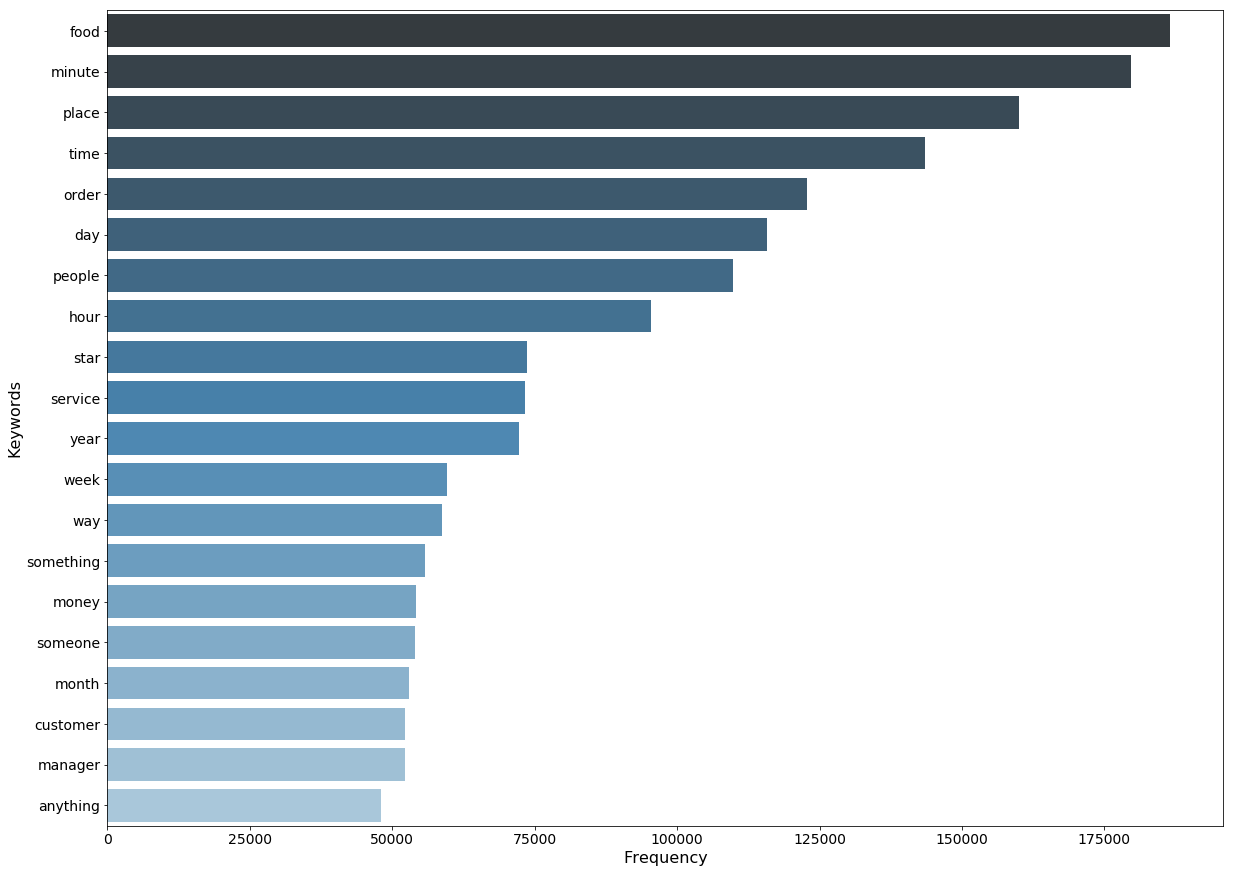

In [24]:
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.barplot(x='Frequency', y='Keywords',data=pandD_bad, palette="Blues_d")
plt.xlabel('Frequency', fontsize=16);
plt.ylabel('Keywords', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)


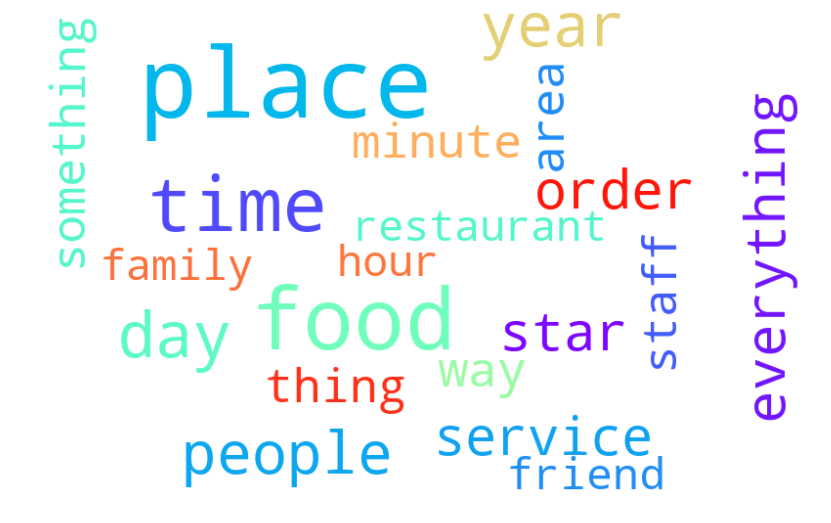

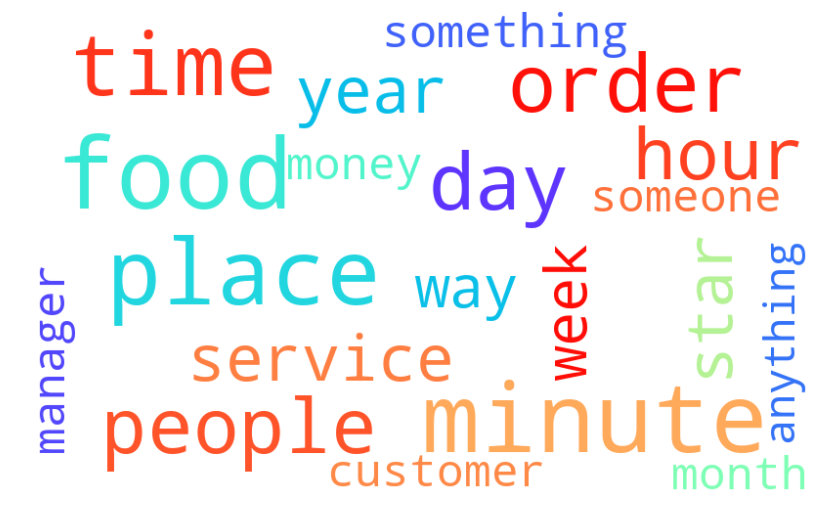

In [25]:
### wordcloud
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud
stop_words = [x[0] for x in freqDist_good_RDD.take(20)]
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])
#stopwords.add("year",'time','day','minute','month','way','week')

wordcloudConvertDF_good = pandD_good.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=1, max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords).generate_from_frequencies(dict(*wordcloudConvertDF_good))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


stop_words = [x[0] for x in freqDist_bad_RDD.take(20)]
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])



wordcloudConvertDF_bad = pandD_bad.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=50, max_font_size=100, relative_scaling=0.5,stopwords = stopwords, background_color="white", colormap='rainbow').generate_from_frequencies(dict(*wordcloudConvertDF_bad))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [46]:
#select top 50
df_good_Dist = freqDist_good_RDD.toDF() #converting RDD to spark dataframe
df_good_Dist.createOrReplaceTempView("myTable") 
df2_good_50 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 50") #renaming columns 
pandD_good_50 = df2_good_50.toPandas() #converting spark dataframes to pandas dataframes


df_bad_Dist = freqDist_bad_RDD.toDF() #converting RDD to spark dataframe
df_bad_Dist.createOrReplaceTempView("myTable") 
df2_bad_50 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable limit 50") #renaming columns 
pandD_bad_50 = df2_bad_50.toPandas() #converting spark dataframes to pandas dataframes


In [47]:
top50good = freqDist_good_RDD.take(50)
pandD_good_50 = pandD_good.set_index('Keywords').T.to_dict('records')
pandD_good_50


[{'anyone': 43533,
  'anything': 50247,
  'area': 84546,
  'bar': 43893,
  'beer': 39325,
  'day': 157906,
  'everyone': 57411,
  'everything': 118145,
  'experience': 63009,
  'family': 67747,
  'feel': 54926,
  'first time': 63840,
  'food': 296926,
  'friend': 71307,
  'get': 41603,
  'home': 51151,
  'hour': 69008,
  'husband': 40950,
  'im': 63126,
  'location': 44173,
  'lot': 40072,
  'meal': 45628,
  'menu': 49558,
  'minute': 87653,
  'month': 43192,
  'new orleans': 38038,
  'night': 47671,
  'order': 111694,
  'people': 134592,
  'pizza': 42775,
  'place': 404996,
  'price': 47587,
  'reservation': 38825,
  'restaurant': 66856,
  'review': 51704,
  'room': 38576,
  'service': 105871,
  'something': 86044,
  'spot': 42008,
  'staff': 81651,
  'star': 113252,
  'thing': 80103,
  'time': 229992,
  'town': 37566,
  'try': 45249,
  'visit': 40779,
  'way': 90238,
  'week': 61230,
  'work': 37724,
  'year': 144063}]

In [48]:
top50bad = freqDist_bad_RDD.take(50)
pandD_bad_50 = pandD_bad.set_index('Keywords').T.to_dict('records')
pandD_bad_50


[{'anyone': 26948,
  'anything': 47977,
  'bar': 25095,
  'bill': 29210,
  'business': 31654,
  'car': 47503,
  'company': 31569,
  'customer': 52279,
  'customer service': 31221,
  'day': 115861,
  'employee': 38257,
  'everything': 32134,
  'experience': 39824,
  'food': 186581,
  'friend': 31024,
  'get': 28317,
  'guy': 27191,
  'hour': 95411,
  'im': 36149,
  'location': 34729,
  'manager': 52152,
  'min': 43254,
  'minute': 179715,
  'money': 54149,
  'month': 52978,
  'night': 27192,
  'nothing': 44312,
  'order': 122814,
  'people': 109843,
  'person': 38047,
  'phone': 32885,
  'place': 160075,
  'price': 29828,
  'restaurant': 39928,
  'review': 39356,
  'room': 42686,
  'service': 73220,
  'someone': 54018,
  'something': 55709,
  'staff': 30273,
  'star': 73676,
  'table': 26680,
  'thing': 46354,
  'time': 143594,
  'today': 30833,
  'u': 25096,
  'way': 58742,
  'week': 59552,
  'work': 25994,
  'year': 72161}]

In [72]:
pandD_good_50_dict = dict(*pandD_good_50)
pandD_bad_50_dict = dict(*pandD_bad_50)
no_overlap_good = [{x:pandD_good_50_dict[x]for x in pandD_good_50_dict if x not in pandD_bad_50_dict}]
no_overlap_good

[{'area': 84546,
  'beer': 39325,
  'everyone': 57411,
  'family': 67747,
  'feel': 54926,
  'first time': 63840,
  'home': 51151,
  'husband': 40950,
  'lot': 40072,
  'meal': 45628,
  'menu': 49558,
  'new orleans': 38038,
  'pizza': 42775,
  'reservation': 38825,
  'spot': 42008,
  'town': 37566,
  'try': 45249,
  'visit': 40779}]

In [73]:
no_overlap_bad = [{x:pandD_bad_50_dict[x] for x in pandD_bad_50_dict if x not in pandD_good_50_dict}]
no_overlap_bad

[{'bill': 29210,
  'business': 31654,
  'car': 47503,
  'company': 31569,
  'customer': 52279,
  'customer service': 31221,
  'employee': 38257,
  'guy': 27191,
  'manager': 52152,
  'min': 43254,
  'money': 54149,
  'nothing': 44312,
  'person': 38047,
  'phone': 32885,
  'someone': 54018,
  'table': 26680,
  'today': 30833,
  'u': 25096}]

In [88]:
no_overlap_good_dict = dict(*no_overlap_good)
no_overlap_good_convert = [{'Keyword': x,'Count':int(no_overlap_good_dict[x])} for x in no_overlap_good_dict]
no_overlap_good_convert
#col = ['Keywords','Count']
no_overlap_good_df = spark.createDataFrame(no_overlap_good_convert)
no_overlap_good_df = no_overlap_good_df.sort('Count').orderBy(['Count'],ascending=[0])
no_overlap_good_df.show()

/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/sql/session.py:357: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+-----------+
|Count|    Keyword|
+-----+-----------+
|84546|       area|
|67747|     family|
|63840| first time|
|57411|   everyone|
|54926|       feel|
|51151|       home|
|49558|       menu|
|45628|       meal|
|45249|        try|
|42775|      pizza|
|42008|       spot|
|40950|    husband|
|40779|      visit|
|40072|        lot|
|39325|       beer|
|38825|reservation|
|38038|new orleans|
|37566|       town|
+-----+-----------+



In [89]:
no_overlap_bad_dict = dict(*no_overlap_bad)
no_overlap_bad_convert = [{'Keyword': x,'Count':int(no_overlap_bad_dict[x])} for x in no_overlap_bad_dict]
no_overlap_bad_convert
#col = ['Keywords','Count']
no_overlap_bad_df = spark.createDataFrame(no_overlap_bad_convert)
no_overlap_bad_df = no_overlap_bad_df.sort('Count').orderBy(['Count'],ascending=[0])
no_overlap_bad_df.show()

/opt/cloudera/parcels/CDH/lib/spark/python/lib/pyspark.zip/pyspark/sql/session.py:357: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


+-----+----------------+
|Count|         Keyword|
+-----+----------------+
|54149|           money|
|54018|         someone|
|52279|        customer|
|52152|         manager|
|47503|             car|
|44312|         nothing|
|43254|             min|
|38257|        employee|
|38047|          person|
|32885|           phone|
|31654|        business|
|31569|         company|
|31221|customer service|
|30833|           today|
|29210|            bill|
|27191|             guy|
|26680|           table|
|25096|               u|
+-----+----------------+



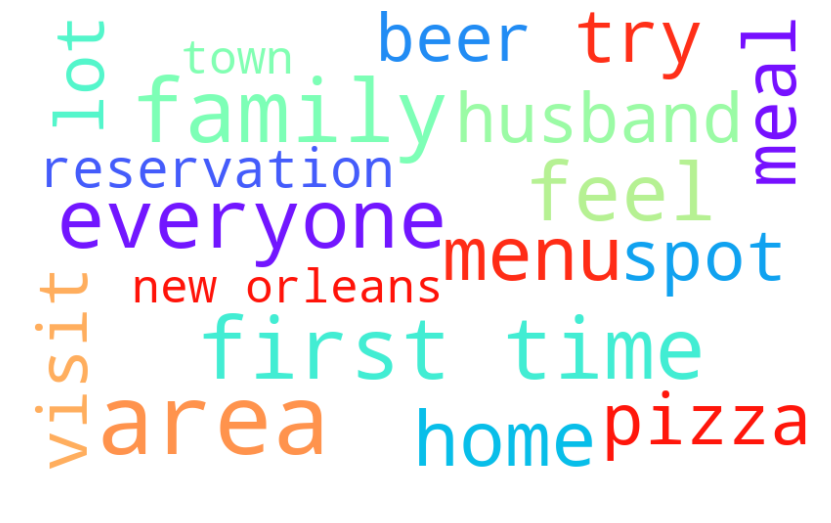

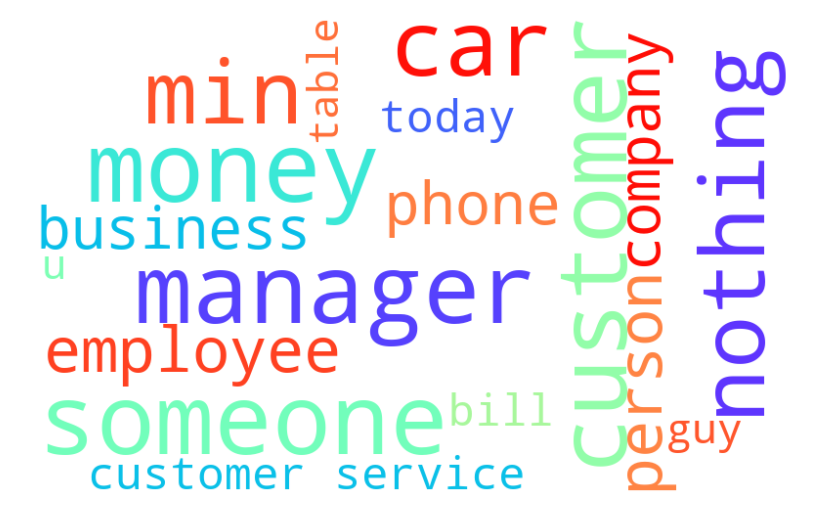

In [74]:
### wordcloud
from itertools import chain

from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud
stop_words = [x[0] for x in freqDist_good_RDD.take(20)]
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])
#stopwords.add("year",'time','day','minute','month','way','week')

wordcloudConvertDF_good = pandD_good.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=1, max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords).generate_from_frequencies(dict(*no_overlap_good))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


stop_words = [x[0] for x in freqDist_bad_RDD.take(20)]
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])



wordcloudConvertDF_bad = pandD_bad.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=50, max_font_size=100, relative_scaling=0.5,stopwords = stopwords, background_color="white", colormap='rainbow').generate_from_frequencies(dict(*no_overlap_bad))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [30]:
mask = np.array(Image.open("yelp4.png"))
mask

array([[8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8]], dtype=uint8)

In [31]:
#transform mask image (yelp logo) to the right size and format through numpy
mask = np.array(Image.open("yelp4.png"))

def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
transform_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
for i in range(len(mask)):
    transform_mask[i] = list(map(transform_format, mask[i]))
    
transform_mask

array([[8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       [8, 8, 8, ..., 7, 7, 7],
       ...,
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8],
       [7, 7, 7, ..., 8, 8, 8]], dtype=int32)

In [32]:
df_good_Dist.createOrReplaceTempView("myTable") 
df2_good_all = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable LIMIT 200") #renaming columns 
pandD_good_all = df2_good_all.toPandas() #converting spark dataframes to pandas dataframes
#pandD_good_all.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))
#df_good_Dist_conv = df_good_Dist.toDF().toPandas()


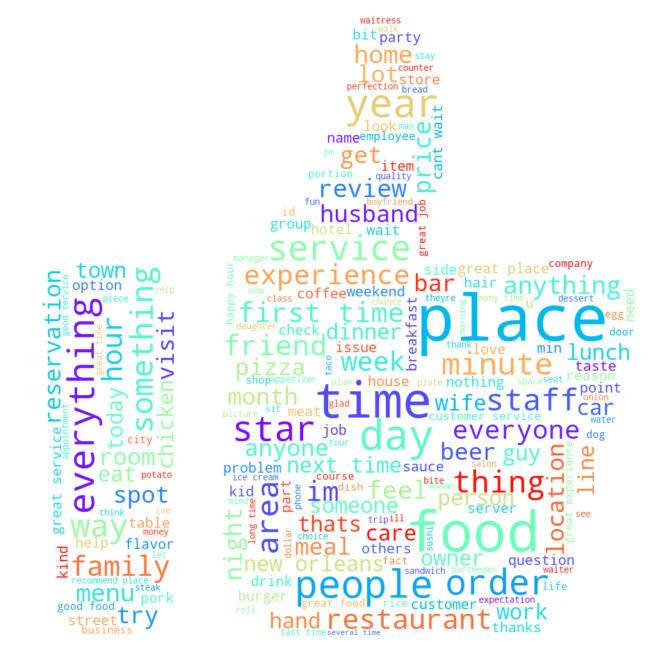

In [33]:
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])
#stopwords.add("year",'time','day','minute','month','way','week')
#my_dpi = 200
mask = np.array(Image.open("thumbup2.png"))

wordcloudConvertDF_good = pandD_good_all.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=1, max_words=1000,max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords, mask = mask).generate_from_frequencies(dict(*wordcloudConvertDF_good))

#wordcloud = WordCloud(width=800/my_dpi, height=500/my_dpi, random_state=1, max_words=1000,max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords, mask = transform_mask).generate_from_frequencies(dict(*wordcloudConvertDF_good))
plt.figure(figsize=(16, 9))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad = 0)
plt.axis('off')
plt.show()

In [34]:
mask = np.array(Image.open("thumbdown1.png"))
mask

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [35]:
df_bad_Dist.createOrReplaceTempView("myTable") 

df2_bad_all = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTable LIMIT 200") #renaming columns 
pandD_bad_all = df2_bad_all.toPandas() #converting spark dataframes to pandas dataframes
#pandD_bad_all.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

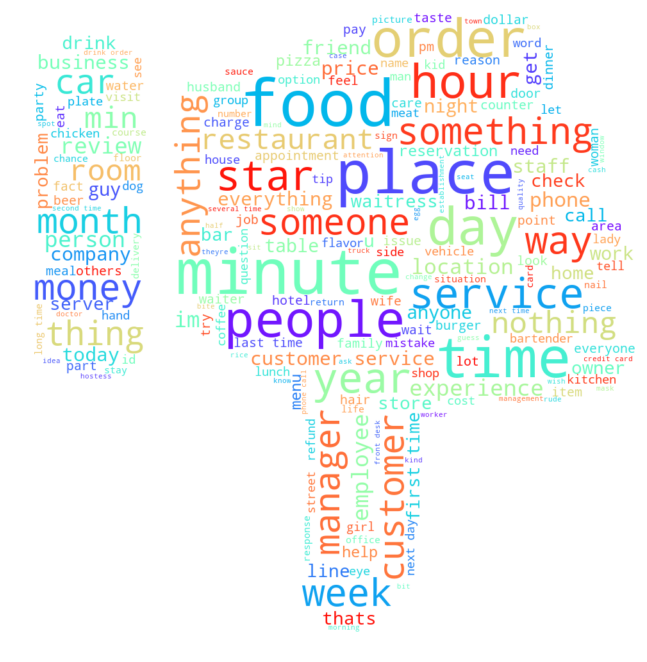

In [36]:
stopwords = set(STOPWORDS)
stopwords.update(["year",'time','day','minute','month','way','week','hour'])
#stopwords.add("year",'time','day','minute','month','way','week')
#my_dpi = 200

wordcloudConvertDF_bad = pandD_bad_all.set_index('Keywords').T.to_dict('records')
wordcloud = WordCloud(width=800, height=500, random_state=1, max_words=1000,max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords, mask = mask).generate_from_frequencies(dict(*wordcloudConvertDF_bad))

#wordcloud = WordCloud(width=800/my_dpi, height=500/my_dpi, random_state=1, max_words=1000,max_font_size=100, relative_scaling=0.5,background_color="white", colormap='rainbow', collocations=False, stopwords = stopwords, mask = transform_mask).generate_from_frequencies(dict(*wordcloudConvertDF_good))
plt.figure(figsize=(16, 9))    
plt.imshow(wordcloud, interpolation="bilinear")
plt.tight_layout(pad = 0)
plt.axis('off')
plt.show()